# Arabic sentiment analysis

This notebook aims to explore the topic of Arabic sentiment analysis. First by attempting some classical ML models trained on the [arabic-sentiment-twitter-corpus](https://www.kaggle.com/mksaad/arabic-sentiment-twitter-corpus) (dataset 1 in the table below) and evaluated on 3 other sentiment-labelled Arabic datasets (datasets 2, 3, and 4 in the table below). I then  move to trying a deep learning approach through finetuning an [Arabic-BERT model](https://github.com/alisafaya/Arabic-BERT) trained on ~8.2 billion words. I do some iterations on variations of the model, evaluating on the same 3 datasets, and then attempt changing the training dataset (trying datasets 2, 3 and 4 as training datasets) and seeing how it affects the overall performance and the model's ability to generalize.

The following table summarizes the datasets used throughout this notebook.

| dataset ID | dataset name| is_dialectical | is_MSA (Modern Standard Arabic) | is_balanced | num_of_tweets | num_of_pos_tweets | num_of_neg_tweets |
|-- | :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| 1 | [arabic-sentiment-twitter-corpus](https://www.kaggle.com/mksaad/arabic-sentiment-twitter-corpus) | Yes | No/minority | Yes | 58,751 | 29,849 | 28,902  
| 2 |[SS2030](https://www.kaggle.com/snalyami3/arabic-sentiment-analysis-dataset-ss2030-dataset ) | Yes - Saudi dialect only | No/Minority | Yes | 4,252 | 2,436 | 1,816 
| 3 |[100k Arabic Reviews](https://www.kaggle.com/abedkhooli/arabic-100k-reviews ) | No/Minority | Yes | Yes | 66,666 | 33,333 | 33,333
| 4 | [ArSAS](https://homepages.inf.ed.ac.uk/wmagdy/resources.htm) | Yes - mixed dialects| No/Minority | Yes | 11,784 | 4,400 | 7,384

*(For a more detailed analysis of the datasets see [this](https://www.kaggle.com/yasmeenhany/dataset-analysis) companion notebook. )*

# Table of Contents:
* [Classic ML Approach](#1)
    * [Compare classifiers](#1.1)
    * [Evaluate best classifier's performance on other datasets](#1.2)
    * [Summary of classic ML results](#1.3)
* [Deep Learning Approach](#2)
 * [BERT-mini](#2.1)
     * [Preprocessing](#2.1.1)
     * [Create data loaders for test and validation sets](#2.1.2)
     * [Define model initialization class and functions](#2.1.3)
     * [Define model train and evaluate functions](#2.1.4)
     * [Initialize and train model](#2.1.5)
     * [Save model](#2.1.6)
     * [Define prediction and test set evaluation functions](#2.1.7)
     * [Predict and evaluate validation subset](#2.1.8)
     * [Predict and evaluate test subset](#2.1.9)
     * [Predict and evaluate on other test datasets](#2.1.10)
     * [Summary of performance on test datasets](#2.1.11)
 * [BERT-mini without emojis](#2.2)
    * [Define modified preprocessing function](#2.2.1)
    * [Preprocess and create data loaders](#2.2.2)
    * [Train](#2.2.3)
    * [Evaluate on test datasets](#2.2.4)
    * [Summary of performance on test datasets](#2.2.5)
        
 * [BERT-base without emojis](#2.3)
    * [Preprocess and create data loaders](#2.3.1)
    * [Train](#2.3.2)
    * [Save trained model](#2.3.3)
    * [Evaluate on test datasets](#2.3.4)
    * [Summary of performance on test datasets](#2.3.5)
 * [Training on other datasets (2, 3 and 4)](#2.4)
    * [Train using the SS2030 dataset](#2.4.1)
    * [Train using the 100k Arabic Reviews dataset](#2.4.2)
    * [Train using the ArSAS dataset](#2.4.3)
    * [Summary of performance on test datasets](#2.4.4)
    * [Train BERT-base Using the ArSAS Dataset](#2.4.5)
 
* [Summary](#3)


In [1]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

%matplotlib inline

#### Load dataset 1

In [2]:
pd.set_option('display.max_colwidth', 280)
train_neg = pd.read_csv("../input/arabic-sentiment-twitter-corpus/train_Arabic_tweets_negative_20190413.tsv", sep="\t", header=None,  quoting=csv.QUOTE_NONE)
train_neg.rename(columns={0:'label', 1:'tweet'}, inplace=True)
train_neg['label'] = 0

train_pos = pd.read_csv("../input/arabic-sentiment-twitter-corpus/train_Arabic_tweets_positive_20190413.tsv", sep="\t", header=None,  quoting=csv.QUOTE_NONE)
train_pos.rename(columns={0:'label', 1:'tweet'}, inplace=True)
train_pos['label'] = 1


train_df = pd.concat([train_neg, train_pos], axis=0).reset_index(drop=True)


from sklearn.model_selection import train_test_split
X = train_df.tweet.values
y = train_df.label.values

# The train val split is used by the DL approach but not classical ML
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.1, random_state=2020)
# Load test subset
test_pos = pd.read_csv("../input/arabic-sentiment-twitter-corpus/test_Arabic_tweets_positive_20190413.tsv", sep="\t", header=None,  quoting=csv.QUOTE_NONE)
test_pos.rename(columns={0:'label', 1:'tweet'}, inplace=True)
test_pos['label']=1

test_neg = pd.read_csv("../input/arabic-sentiment-twitter-corpus/test_Arabic_tweets_negative_20190413.tsv", sep="\t", header=None,  quoting=csv.QUOTE_NONE)
test_neg.rename(columns={0:'label', 1:'tweet'}, inplace=True)
test_neg['label']=0

test_df = pd.concat([test_neg, test_pos], axis=0).reset_index(drop=True)
X_test = test_df.tweet.values
y_test = test_df.label.values


#### Load other test datasets (datasets 2, 3 and 4): (to test how well model generalizes on arabic tweets/short text)
& preprocess such that each dataset's dataframe has two columns:
1) **tweet**: tweet text 

2) **label**: representing sentiment, with 1 being positive and 0 negative

See this [companion notebook](https://www.kaggle.com/yasmeenhany/dataset-analysis?scriptVersionId=64595722) for a comparison of the datasets in terms of emoji presence, vocabulary similarity, vocabulary histograms, etc.

In [3]:
df_ss2030 = pd.read_csv("../input/arabic-sentiment-analysis-dataset-ss2030-dataset/Arabic Sentiment Analysis Dataset - SS2030.csv")
# Rename columns to match convention
df_ss2030 = df_ss2030.rename(columns = {"text":"tweet", "Sentiment": "label"})

In [4]:
df_reviews = pd.read_csv("../input/arabic-100k-reviews/ar_reviews_100k.tsv", delimiter="\t")
# Create a mapping for the labels such that we use the same convention across all datasets
label_mapping = {"Positive": 1, "Negative":0}
# Filter to only have pos and neg tweets, i.e: remove mixed tweets
df_reviews = df_reviews[df_reviews.label != "Mixed"]
df_reviews["label"] = df_reviews["label"].map(label_mapping)
# Rename columns to match convention
df_reviews = df_reviews.rename(columns = {"text":"tweet"})

In [5]:
df_arsas = pd.read_csv('../input/arsas-dataset/ArSAS..txt', header = 0, delimiter = "\t")
# Filter to only have pos and neg tweets, i.e: remove mixed tweets
df_arsas_pos = df_arsas[df_arsas.Sentiment_label == 'Positive'] 
df_arsas_neg = df_arsas[df_arsas.Sentiment_label == 'Negative'] 
df_arsas = pd.concat([df_arsas_pos, df_arsas_neg], axis=0).reset_index(drop=True)
# Create a mapping for the labels such that we use the same convention across all datasets
label_mapping = {"Positive": int(1), "Negative":int(0)}
df_arsas["Sentiment_label"] = df_arsas["Sentiment_label"].map(label_mapping)
# Rename columns to match convention
df_arsas = df_arsas.rename(columns = {"Tweet_text":"tweet", "Sentiment_label":"label"})

<a id="1"></a>
# Classical ML approach
#### Using tf-idf features

In [6]:
# Helper functions 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
def train_model(model, data, targets):
    text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', model),
    ])
    text_clf.fit(data, targets)
    return text_clf
def get_accuracy(trained_model,X, y):
    predicted = trained_model.predict(X)
    accuracy = np.mean(predicted == y)
    return accuracy

<a id="1.1"></a>
### Compare classifiers

In [7]:
from sklearn.tree import DecisionTreeClassifier
trained_clf_decision_tree = train_model(DecisionTreeClassifier(), X, y)
accuracy = get_accuracy(trained_clf_decision_tree,X_test, y_test)
print(f"Test dataset accuracy with DecisionTreeClassifier: {accuracy:.2f}")

Test dataset accuracy with DecisionTreeClassifier: 0.77


In [8]:
from sklearn.naive_bayes import MultinomialNB
trained_clf_multinomial_nb = train_model(MultinomialNB(), X, y)
accuracy = get_accuracy(trained_clf_multinomial_nb,X_test, y_test)
print(f"Test dataset accuracy with MultinomialNB: {accuracy:.2f}")

Test dataset accuracy with MultinomialNB: 0.79


In [9]:
from sklearn.svm import LinearSVC
trained_clf_linearSVC = train_model(LinearSVC(), X, y)
accuracy = get_accuracy(trained_clf_linearSVC,X_test, y_test)
print(f"Test dataset accuracy with LinearSVC: {accuracy:.2f}")

Test dataset accuracy with LinearSVC: 0.79


In [10]:
from sklearn.ensemble import RandomForestClassifier
trained_clf_random_forest = train_model(RandomForestClassifier(), X, y)
accuracy = get_accuracy(trained_clf_random_forest,X_test, y_test)
print(f"Test dataset accuracy with RandomForestClassifier: {accuracy:.2f}")

Test dataset accuracy with RandomForestClassifier: 0.80


Because no classifier is yielding a significantly better accuracy on the arabic-sentiment-twitter-corupus test subset, will evaluate all classifiers against the other test datasets, to get a more general idea about their performance (measured by accuracy)

<a id="1.2"></a>
### Evaluate classifiers on other datasets

In [11]:
def print_all_accuracies(dataset_name, dataset):
  accuracy = get_accuracy(trained_clf_decision_tree,dataset.tweet.values, dataset.label.values)
  print(f"{dataset_name} dataset accuracy with Decision Tree: {accuracy:.2f}")
  accuracy = get_accuracy(trained_clf_multinomial_nb,dataset.tweet.values, dataset.label.values)
  print(f"{dataset_name} dataset accuracy with Multinomial NB: {accuracy:.2f}")
  accuracy = get_accuracy(trained_clf_linearSVC,dataset.tweet.values, dataset.label.values)
  print(f"{dataset_name} dataset accuracy with Linear SVC: {accuracy:.2f}")
  accuracy = get_accuracy(trained_clf_random_forest,dataset.tweet.values, dataset.label.values)
  print(f"{dataset_name} dataset accuracy with Random Forest: {accuracy:.2f}")

In [12]:
print_all_accuracies("SS2030", df_ss2030)
print_all_accuracies("100k Arabic Reviews", df_reviews)
print_all_accuracies("ArSAS", df_arsas)

SS2030 dataset accuracy with Decision Tree: 0.53
SS2030 dataset accuracy with Multinomial NB: 0.59
SS2030 dataset accuracy with Linear SVC: 0.58
SS2030 dataset accuracy with Random Forest: 0.54
100k Arabic Reviews dataset accuracy with Decision Tree: 0.55
100k Arabic Reviews dataset accuracy with Multinomial NB: 0.60
100k Arabic Reviews dataset accuracy with Linear SVC: 0.58
100k Arabic Reviews dataset accuracy with Random Forest: 0.59
ArSAS dataset accuracy with Decision Tree: 0.51
ArSAS dataset accuracy with Multinomial NB: 0.65
ArSAS dataset accuracy with Linear SVC: 0.61
ArSAS dataset accuracy with Random Forest: 0.66


<a id= "1.3"> </a>
### Summary of Classic ML Results:
- Best classfiers found for the `arabic-sentiment-twitter-corpus` dataset: **RandomForestClassifier** 
- Performance across test datasets (numbers represent accuracy):

| Dataset | Decision Tree | Multinomial NB | Linear SVC | Random Forest
| :---: | :---: | :---: | :---: | :---: |
| arabic-sentiment-twitter-corpus test subset | 0.77 | 0.79 | 0.79 | **0.8** 
| SS2030 | 0.52 | **0.59** | 0.58 | 0.55
| 100k reviews | 0.54 | **0.60** | 0.58 | 0.59
| ArSAS | 0.51 | 0.65 | 0.61 | **0.66** 
    

    
- It appears that **Multinomial NB** can sometimes outperform Random Forest but the differences are insignificant. 


# Deep Learning Approach
- Given that the Random Forest Classifier model wasn't generalizing well for other datasets (possibly overfitting), I decided to try a DL approach using a pretrained model (i.e: increasing the dataset as a way of overcoming overfitting). For that I chose to use the [Arabic-BERT model](https://github.com/alisafaya/Arabic-BERT) By Ali Safaya.  
> The models were pretrained on ~8.2 Billion words:
> - Arabic version of OSCAR (unshuffled version of the corpus) - filtered from Common Crawl
> - Recent dump of Arabic Wikipedia

In [13]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla P100-PCIE-16GB


In [14]:
from transformers import AutoTokenizer, AutoModel

<a id="2.1"> </a>
### BERT-mini
Code adapted from https://skimai.com/fine-tuning-bert-for-sentiment-analysis/

In [15]:
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-mini-arabic")

Downloading:   0%|          | 0.00/509 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/334k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

<a id="2.1.1"> </a>
##### Preprocessing

In [16]:
# Define preprocessing util function
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
  

    # Normalize unicode encoding
    text = unicodedata.normalize('NFC', text)
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    #Remove URLs
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '<URL>', text)


    return text

In [17]:
# Create a function to tokenize a set of texts
import emoji
import unicodedata
def preprocessing_for_bert(data, version="mini", text_preprocessing_fn = text_preprocessing ):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []
    tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-mini-arabic") if version == "mini" else AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")

    # For every sentence...
    for i,sent in enumerate(data):
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing_fn(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            padding='max_length',        # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True,     # Return attention mask
            truncation = True 
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [18]:
# Specify `MAX_LEN`
MAX_LEN =  280

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Original:  اعترف ان بتس كانو شوي شوي يجيبو راسي لكن اليوم بالزايد 😭
Token IDs:  [2, 14416, 1732, 9686, 1841, 1009, 17818, 17818, 14472, 1009, 23388, 2356, 2055, 10483, 2442, 998, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


<a id="2.1.2"> </a>
##### Create data loaders for test and validation sets

In [19]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

<a id="2.1.3"> </a>
##### Define model initialization class and functions

In [20]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False, version="mini"):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in = 256 if version == "mini" else 768
        H, D_out = 50, 2

        # Instantiate BERT model
        self.bert = AutoModel.from_pretrained("asafaya/bert-mini-arabic") if version == "mini" else AutoModel.from_pretrained("asafaya/bert-base-arabic")
        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 129 µs, sys: 0 ns, total: 129 µs
Wall time: 132 µs


In [21]:
from transformers import AdamW, get_linear_schedule_with_warmup

from torch.optim import SparseAdam, Adam
def initialize_model(epochs=4, version="mini"):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False, version=version)
    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(params=list(bert_classifier.parameters()),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

<a id="2.1.4"> </a>
##### Define model train and evaluate functions

In [22]:
import random
import time
import torch
import torch.nn as nn
# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

<a id="2.1.5"> </a>
##### Initialize and train model

In [23]:
set_seed(42) 
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Downloading:   0%|          | 0.00/46.6M [00:00<?, ?B/s]

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.689437   |     -      |     -     |   1.91   
   1    |   40    |   0.665936   |     -      |     -     |   0.93   
   1    |   60    |   0.642909   |     -      |     -     |   0.93   
   1    |   80    |   0.628607   |     -      |     -     |   0.93   
   1    |   100   |   0.595988   |     -      |     -     |   0.94   
   1    |   120   |   0.591557   |     -      |     -     |   0.93   
   1    |   140   |   0.481050   |     -      |     -     |   0.93   
   1    |   160   |   0.476013   |     -      |     -     |   0.94   
   1    |   180   |   0.492065   |     -      |     -     |   0.93   
   1    |   200   |   0.455702   |     -      |     -     |   0.93   
   1    |   220   |   0.400988   |     -      |     -     |   0.93   
   1    |   240   |   0.486438   |     -      |     -     |   0.93   


<a id="2.1.6"> </a>
##### Save model

In [24]:
# Saving the model for future runs

import pickle
filename = 'trained_model_mini_with_emojis.sav'
pickle.dump(bert_classifier, open(filename, 'wb'))

Load model (Uncomment to avoid retraining in future runs)

In [25]:
# # Loading the model (to avoid retraining in reruns)

# import pickle
# filename = 'trained_model_mini_with_emojis.sav'
# f = open(filename, 'rb')
# bert_classifier = pickle.load(f)

<a id="2.1.7"> </a>
##### Define prediction and test set evaluation functions

In [26]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [27]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true, model_name, dataset_name, test_dataset_name):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title(f" ROC of {model_name}  trained on {dataset_name} dataset & evaluated on the {test_dataset_name} dataset ")
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

<a id="2.1.8"> </a>
##### Predict and evaluate validation subset

AUC: 0.9628
Accuracy: 90.57%


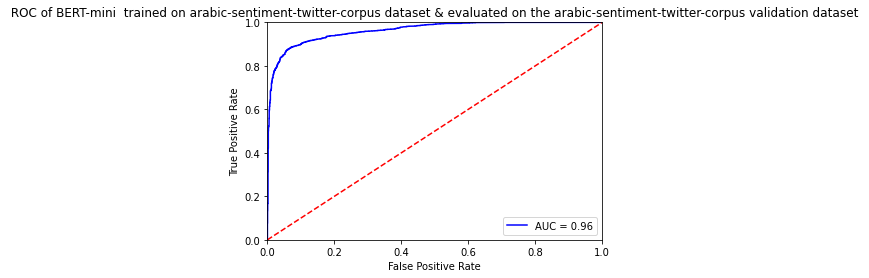

In [28]:
# Compute predicted probabilities on the validation set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val, "BERT-mini", "arabic-sentiment-twitter-corpus", "arabic-sentiment-twitter-corpus validation")

<a id="2.1.9"> </a>
##### Predict and evaluate test subset

In [29]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(X_test)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


In [30]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.5
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("no-negative tweets ratio ", preds.sum()/len(preds))

no-negative tweets ratio  0.4723002297676793


AUC: 0.9658
Accuracy: 90.08%


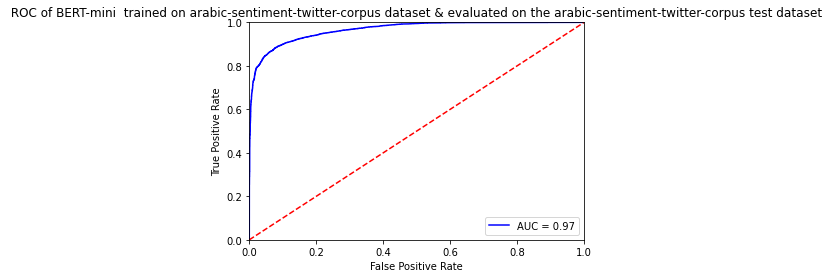

In [31]:
# Evaluate the Bert classifier for unseen test data
evaluate_roc(probs, y_test,"BERT-mini", "arabic-sentiment-twitter-corpus","arabic-sentiment-twitter-corpus test")

<a id="2.1.10"> </a>
##### Predict and evaluate on other test datasets

In [32]:
# Evaluate the performance of a model on test datasets
def evaluate_dataset(sents, labels, model_name, dataset_name, test_dataset_name):
    test_inputs, test_masks = preprocessing_for_bert(sents)

    # Create the DataLoader for our test set
    test_dataset = TensorDataset(test_inputs, test_masks)
    test_sampler = SequentialSampler(test_dataset)
    test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)
    # Compute predicted probabilities on the test set
    probs = bert_predict(bert_classifier, test_dataloader)

    # Get predictions from the probabilities
    threshold = 0.5
    preds = np.where(probs[:, 1] > threshold, 1, 0)
    auc_graph = evaluate_roc(probs, labels, model_name, dataset_name, test_dataset_name )

    return auc_graph

AUC: 0.7260
Accuracy: 63.95%


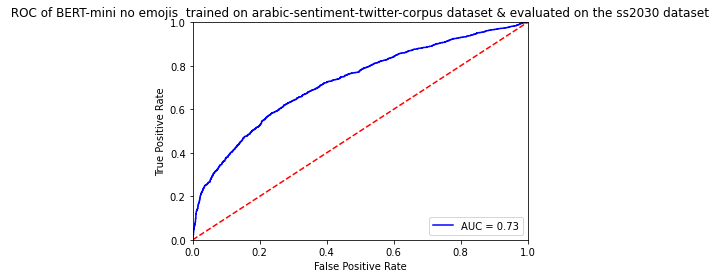

In [33]:
# Evaluate on the SS2030 Dataset
evaluate_dataset(df_ss2030.tweet.values, df_ss2030.label.values,"BERT-mini no emojis", "arabic-sentiment-twitter-corpus", "ss2030" )

AUC: 0.6310
Accuracy: 59.97%


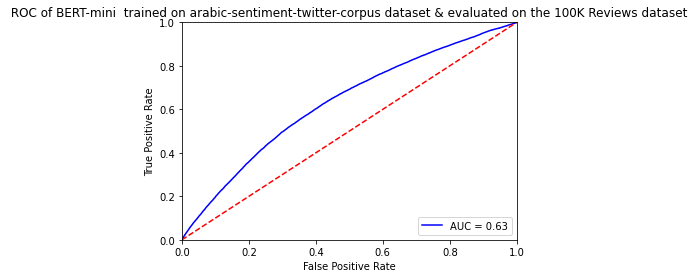

In [34]:
# Evaluate on the 100k Arabic Reviews Dataset
evaluate_dataset(df_reviews.tweet.values, df_reviews.label.values,"BERT-mini", "arabic-sentiment-twitter-corpus", "100K Reviews")

AUC: 0.7620
Accuracy: 69.12%


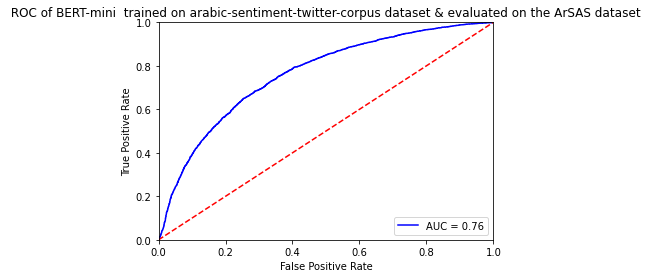

In [35]:
evaluate_dataset(df_arsas.tweet.values, df_arsas.label.values,"BERT-mini", "arabic-sentiment-twitter-corpus", "ArSAS")

<a id="2.1.11"> </a>
##### Summary of performance on test datasets

| Model | arabic-sentiment-twitter-corpus test subset | SS2030 | 100k reviews | ArSAS
| :---: | :---: | :---: | :---: | :---: |
| RandomForestClassifier | 0.798 | 0.554 | 0.587 | 0.660
| BERT-mini | 0.900 | 0.639 | 0.599 | 0.691

<center><i>numbers shown represent accuracy</i></center>

In [36]:
# Helper function to get the prediction of a single tweet's sentiment (can be used for random tweet testing)
def predict_tweet_sentiment(tweet):
    df = pd.DataFrame([tweet])
    df = df.rename(columns = {0:"tweet"})
    print(df.tweet.values)
    test_inputs, test_masks = preprocessing_for_bert(df.tweet.values)

    # Create the DataLoader for our test set
    test_dataset = TensorDataset(test_inputs, test_masks)
    test_sampler = SequentialSampler(test_dataset)
    test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)
    # Compute predicted probabilities on the test set
    probs = bert_predict(bert_classifier, test_dataloader)
    print(probs)
    # Get predictions from the probabilities
    threshold = 0.5
    preds = np.where(probs[:, 1] > threshold, "positive", "negative")

#     print("no-negative tweets ratio ", preds.sum()/len(preds))
    return preds


*While it seems like the DL approach with Arabic BERT improved generalization on other datasets, it seems like there's still a big gap between the performance on the arabic-sentiment-twitter-corpus dataset and the other datasets. I had a suspicion that the model's high accuracy on the first dataset (arabic-sentiment-twitter-corpus) was due to the fact that it uses emojis as cues (From the dataset analysis [notebook](https://www.kaggle.com/yasmeenhany/dataset-analysis?scriptVersionId=64595722) we can see that this dataset has emojis in almost 80% of the tweets while all other datasets' tweets/texts aren't as heavily saturated with emojis). To test this hypothesis, I decided to train the same model, but with removing emojis in the preprocessing step and seeing how it affects accuracy.*

<a id="2.2"> </a>
### BERT-mini without emojis

<a id="2.2.1"> </a>
##### Define modified preprocessing function

In [37]:
def remove_emojis(sent):
    text =  emoji.demojize(sent)
    text= re.sub(r'(:[!_\-\w]+:)', '', text)
    return text

In [38]:
# Redefine the text_processing function to include the remove emojis step
def text_preprocessing_no_emojis(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
  
    # Remove emojis
    text = remove_emojis(text)

    return text_preprocessing(text)

<a id="2.2.2"> </a>
##### Preprocess and create data loaders

In [39]:
# Specify `MAX_LEN`
MAX_LEN =  280

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]], text_preprocessing_fn=text_preprocessing_no_emojis)[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train, text_preprocessing_fn=text_preprocessing_no_emojis)
val_inputs, val_masks = preprocessing_for_bert(X_val, text_preprocessing_fn=text_preprocessing_no_emojis)
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

Original:  اعترف ان بتس كانو شوي شوي يجيبو راسي لكن اليوم بالزايد 😭
Token IDs:  [2, 14416, 1732, 9686, 1841, 1009, 17818, 17818, 14472, 1009, 23388, 2356, 2055, 10483, 2442, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


<a id="2.2.3"> </a>
##### Train

In [40]:
set_seed(42) 
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.694156   |     -      |     -     |   0.99   
   1    |   40    |   0.687947   |     -      |     -     |   0.94   
   1    |   60    |   0.671429   |     -      |     -     |   0.94   
   1    |   80    |   0.664775   |     -      |     -     |   0.94   
   1    |   100   |   0.666962   |     -      |     -     |   1.04   
   1    |   120   |   0.650303   |     -      |     -     |   0.94   
   1    |   140   |   0.653849   |     -      |     -     |   0.93   
   1    |   160   |   0.631842   |     -      |     -     |   0.94   
   1    |   180   |   0.679908   |     -      |     -     |   0.94   
   1    |   200   |   0.644687   |     -      |     -     |   0.94   
   1    |   220   |   0.619921   |     -      |     -     |   0.94   
   1    |   240   |   0.650214   |     -      |     -     |   0.94   


*As hypothesized, it seems like the presence/absence of emojis can greatly affect model performance in terms of accuracy, given how the accuracy went from 0.90 to 0.79 after only removing emojis in the preprocessing step*

<a id="2.2.4"> </a>
##### Evaluate on test datasets

AUC: 0.8765
Accuracy: 79.30%


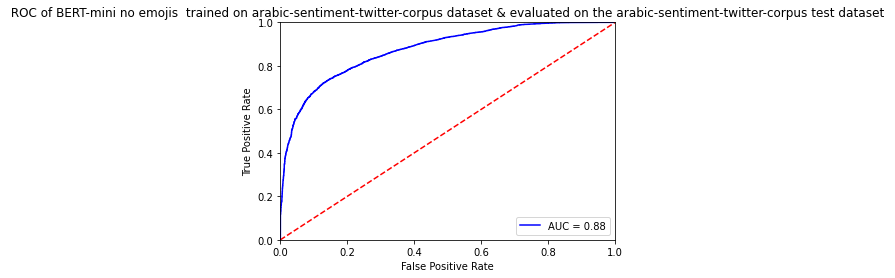

In [41]:
# Evaluate on the unseen test data
evaluate_dataset(X_test, y_test,"BERT-mini no emojis", "arabic-sentiment-twitter-corpus", "arabic-sentiment-twitter-corpus test")

AUC: 0.7044
Accuracy: 63.59%


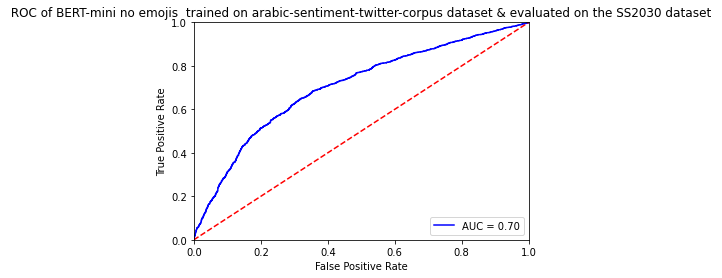

In [42]:
# Evaluate on the SS2030 Dataset
evaluate_dataset(df_ss2030.tweet.values, df_ss2030.label.values,"BERT-mini no emojis", "arabic-sentiment-twitter-corpus", "SS2030")

AUC: 0.6543
Accuracy: 63.25%


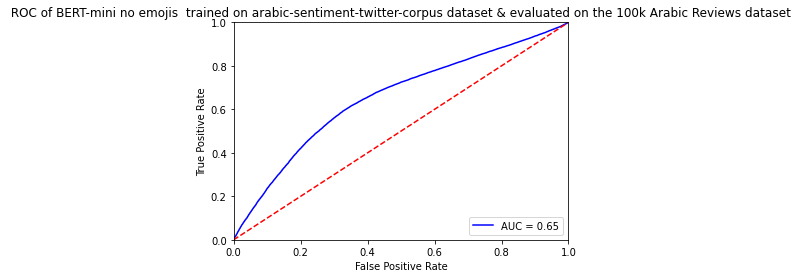

In [43]:
# Evaluate on the 100k Arabic Reviews Dataset
evaluate_dataset(df_reviews.tweet.values, df_reviews.label.values,"BERT-mini no emojis","arabic-sentiment-twitter-corpus", "100k Arabic Reviews")

AUC: 0.7138
Accuracy: 66.87%


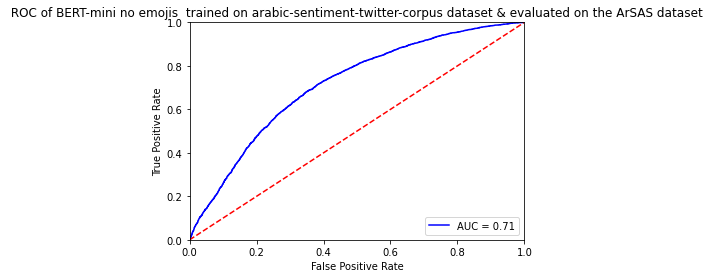

In [44]:
# Evaluate on the ArSAS Dataset
evaluate_dataset(df_arsas.tweet.values, df_arsas.label.values,"BERT-mini no emojis", "arabic-sentiment-twitter-corpus", "ArSAS")

<a id="2.2.5"> </a>
##### Summary of performance on test datasets

| Model | arabic-sentiment-twitter-corpus test subset | SS2030 | 100k reviews | ArSAS
| :---: | :---: | :---: | :---: | :---: |
| RandomForestClassifier | 0.798 | 0.554 | 0.587 | 0.660
| BERT-mini | 0.900 | 0.639 | 0.599 | 0.691
| BERT-mini without emojis | 0.785 | 0.628 | 0.632 | 0.663

<center><i>numbers shown represent accuracy</i></center>

Compared to BERT-mini with emojis, BERT-mini without emojis' accuracy has dropped across all datasets. This, however, is expected since the model was learning from emojis, which is undesired behavior (we want a text sentiment classifier). Compared to the Random Forest Classifier, it seems like the BERT-mini without emojis' performance has slightly dropped on the `arabic-sentiment-twitter-corpus` test subset, but improved on the other test datasets (2, 3 and 4). Given that this version has generalized better on other datasets, let's try to see how BERT-base without emojis performs in comparison.  

<a id="2.3"> </a>
### BERT-base

<a id="2.3.1"> </a>
##### Preprocess and create data loaders

In [45]:
# Specify `MAX_LEN`
MAX_LEN =  280

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]], version="base", text_preprocessing_fn=text_preprocessing_no_emojis)[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train, version="base", text_preprocessing_fn=text_preprocessing_no_emojis)
val_inputs, val_masks = preprocessing_for_bert(X_val, version="base", text_preprocessing_fn=text_preprocessing_no_emojis)
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)



Downloading:   0%|          | 0.00/491 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/334k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

Original:  اعترف ان بتس كانو شوي شوي يجيبو راسي لكن اليوم بالزايد 😭
Token IDs:  [2, 14416, 1732, 9686, 1841, 1009, 17818, 17818, 14472, 1009, 23388, 2356, 2055, 10483, 2442, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


<a id="2.3.2"> </a>
##### Train

In [46]:
set_seed(42) 
bert_classifier, optimizer, scheduler = initialize_model(epochs=2, version="base")
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.705731   |     -      |     -     |   9.74   
   1    |   40    |   0.671783   |     -      |     -     |   9.20   
   1    |   60    |   0.686350   |     -      |     -     |   9.33   
   1    |   80    |   0.681769   |     -      |     -     |   9.20   
   1    |   100   |   0.672884   |     -      |     -     |   9.20   
   1    |   120   |   0.622739   |     -      |     -     |   9.20   
   1    |   140   |   0.615106   |     -      |     -     |   9.25   
   1    |   160   |   0.653511   |     -      |     -     |   9.21   
   1    |   180   |   0.625046   |     -      |     -     |   9.20   
   1    |   200   |   0.568101   |     -      |     -     |   9.21   
   1    |   220   |   0.650382   |     -      |     -     |   9.23   
   1    |   240   |   0.598752   |     -      |     -     |   9.16   


<a id="2.3.3"> </a>
##### Save trained model

In [47]:
import pickle
filename = 'trained_model_base_without_emojis.sav'
pickle.dump(bert_classifier, open(filename, 'wb'))

<a id="2.3.4"> </a>
##### Evaluate on test datasets

AUC: 0.8986
Accuracy: 81.53%


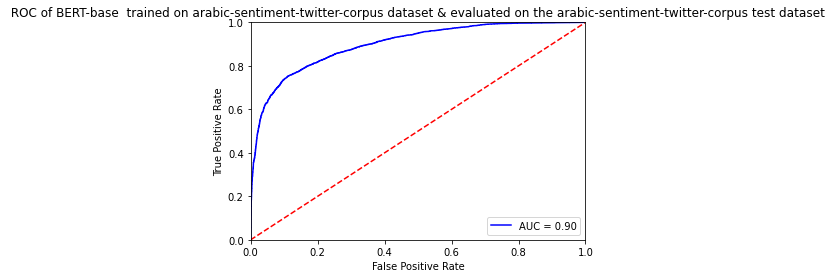

In [48]:
# Evaluate on the unseen test data
evaluate_dataset(X_test, y_test,"BERT-base", "arabic-sentiment-twitter-corpus", "arabic-sentiment-twitter-corpus test")

AUC: 0.7137
Accuracy: 65.57%


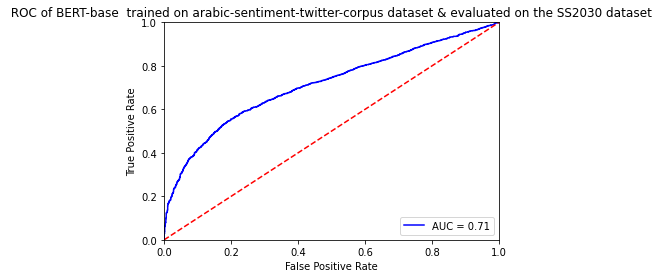

In [49]:
# Evaluate on the SS2030 Dataset
evaluate_dataset(df_ss2030.tweet.values, df_ss2030.label.values,"BERT-base", "arabic-sentiment-twitter-corpus", "SS2030")

AUC: 0.6974
Accuracy: 65.22%


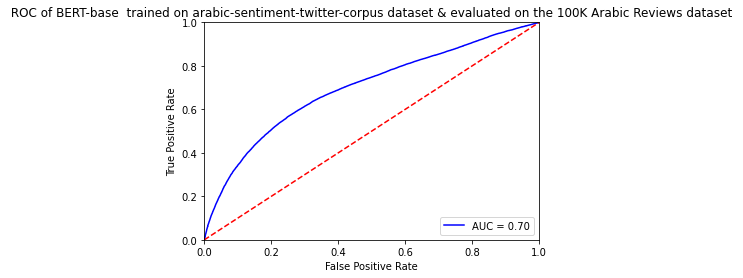

In [50]:
# Evaluate on the 100k Arabic Reviews Dataset
evaluate_dataset(df_reviews.tweet.values, df_reviews.label.values,"BERT-base", "arabic-sentiment-twitter-corpus", "100K Arabic Reviews")

AUC: 0.7665
Accuracy: 70.65%


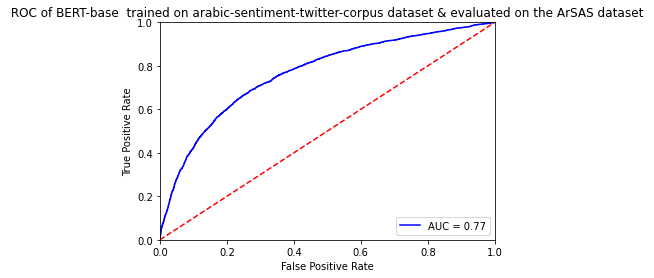

In [51]:
# Evaluate on the ArSAS Dataset
evaluate_dataset(df_arsas.tweet.values, df_arsas.label.values,"BERT-base", "arabic-sentiment-twitter-corpus", "ArSAS")

<a id="2.3.5"> </a>
##### Summary of performance of test datasets
| Model | arabic-sentiment-twitter-corpus test subset | SS2030 | 100k reviews | ArSAS
| :---: | :---: | :---: | :---: | :---: |
| RandomForestClassifier | 0.798 | 0.554 | 0.587 | 0.660
| BERT-mini | 0.900 | 0.639 | 0.599 | 0.691
| BERT-mini without emojis | 0.785 | 0.628 | 0.632 | 0.663
| BERT-base without emojis | 0.803 |  0.652 | 0.652 | 0.699

<center><i>numbers shown represent accuracy</i></center>

*It looks like the BERT-base slightly improved the overall performance on the unseen datasets, but it still appears that the model is unable to generalize well after being trained on the arabic-sentiment-twitter-corpus dataset. To overcome this, we will attempt to train the model on the other datasets, and see on how that reflects on the model's ability to generalize*

<a id="2.4"> </a>
### DL approach trained on other datasets

In [52]:
# Helper function that encapsulates all training logic
from sklearn.model_selection import train_test_split
def train_val_test_split(df):
    X = df.tweet.values
    y = df.label.values

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=2020)
    X_val, X_test, y_val, y_test = train_test_split(X_test,y_test,test_size=0.5, random_state=2020)
    return X_train, X_val, X_test, y_train, y_val, y_test
def preprocess_and_train(X_train, X_val, y_train,y_val):

    # Print sentence 0 and its encoded token ids
    token_ids = list(preprocessing_for_bert([X_train[0]], text_preprocessing_fn=text_preprocessing_no_emojis)[0].squeeze().numpy())
    print('Original: ', X_train[0])
    print('Token IDs: ', token_ids)

    # Run function `preprocessing_for_bert` on the train set and the validation set
    print('Tokenizing data...')
    train_inputs, train_masks = preprocessing_for_bert(X_train, text_preprocessing_fn=text_preprocessing_no_emojis)
    val_inputs, val_masks = preprocessing_for_bert(X_val, text_preprocessing_fn=text_preprocessing_no_emojis)
    from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

    # Convert other data types to torch.Tensor
    train_labels = torch.tensor(y_train)
    val_labels = torch.tensor(y_val)

    # For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
    batch_size = 16

    # Create the DataLoader for our training set
    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create the DataLoader for our validation set
    val_data = TensorDataset(val_inputs, val_masks, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)
    set_seed(42) 
    bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
    train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)
    return bert_classifier

In [53]:
# Concatenate all of the tweets from arabic-sentiment-twitter-corpus to treat it as 1 test dataset in this section
df_twitter_corpus = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

<a id="2.4.1"> </a>
#### Training using the SS2030 Dataset

In [54]:

from sklearn.model_selection import train_test_split
MAX_LEN = 280
X = df_ss2030.tweet.values
y = df_ss2030.label.values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=2020)
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test,test_size=0.5, random_state=2020)


# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X_train[0]], text_preprocessing_fn=text_preprocessing_no_emojis)[0].squeeze().numpy())
print('Original: ', X_train[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train, text_preprocessing_fn=text_preprocessing_no_emojis)
val_inputs, val_masks = preprocessing_for_bert(X_val, text_preprocessing_fn=text_preprocessing_no_emojis)
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)
set_seed(42) 
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Original:  دراسة حديثة 🔴
 
 تعدد الزوجات خطر على قلب الرجل ، و يرفع معدلات الإصابة بأمراض القلب 🤔
Token IDs:  [2, 5009, 8838, 18859, 4186, 1719, 6732, 1747, 4428, 3689, 219, 251, 10612, 13605, 8045, 25717, 4437, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

AUC: 0.9205
Accuracy: 84.27%


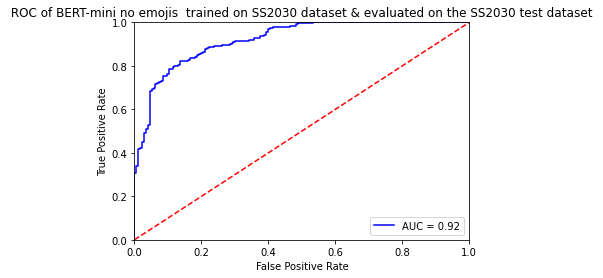

In [55]:
# Evaluate on the unseen dataset
evaluate_dataset(X_test, y_test,"BERT-mini no emojis", "SS2030", "SS2030 test")

AUC: 0.6121
Accuracy: 58.25%


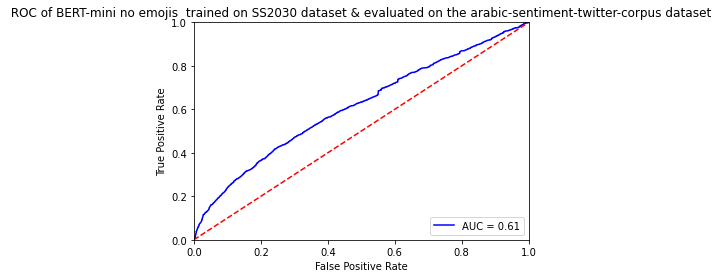

In [56]:
# Evaluate on the twitter corpus dataset
evaluate_dataset(df_twitter_corpus.tweet.values, df_twitter_corpus.label.values,"BERT-mini no emojis", "SS2030", "arabic-sentiment-twitter-corpus" )

AUC: 0.6075
Accuracy: 57.07%


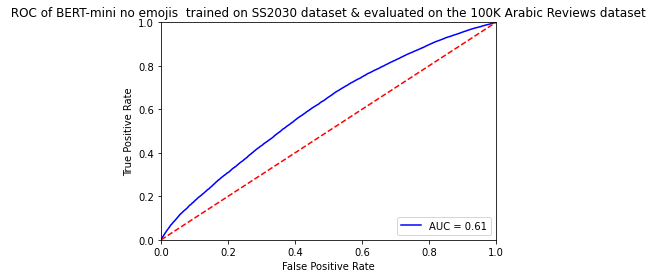

In [57]:
# Evaluate on the 100k Arabic Reviews Dataset
evaluate_dataset(df_reviews.tweet.values, df_reviews.label.values,"BERT-mini no emojis", "SS2030", "100K Arabic Reviews")

AUC: 0.7374
Accuracy: 70.14%


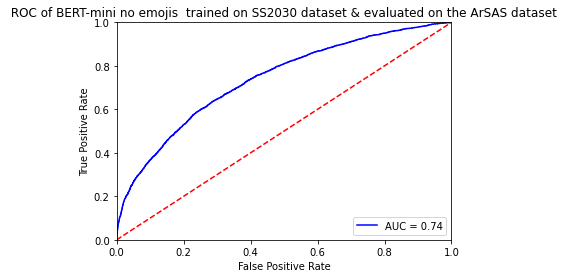

In [58]:
# Evaluate on the ArSAS Dataset
evaluate_dataset(df_arsas.tweet.values, df_arsas.label.values,"BERT-mini no emojis", "SS2030", "ArSAS")

<a id="2.4.2"> </a>
#### Train using the 100k Arabic Reviews dataset

In [59]:

from sklearn.model_selection import train_test_split
MAX_LEN = 280
X = df_reviews.tweet.values
y = df_reviews.label.values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=2020)
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test,test_size=0.5, random_state=2020)


# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X_train[0]], text_preprocessing_fn=text_preprocessing_no_emojis)[0].squeeze().numpy())
print('Original: ', X_train[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train, text_preprocessing_fn=text_preprocessing_no_emojis)
val_inputs, val_masks = preprocessing_for_bert(X_val, text_preprocessing_fn=text_preprocessing_no_emojis)
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)
set_seed(42) 
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Original:  أعطتني خلفية لا بأس بها بديانات القرن السادس عشر .. بوذا و النافاري ... لم أفهم بدايتها وعندما هبط هن تشو كان الي قرية المصرية ترابطت الأحداث وفهمت كيف سيظهر د رفعت. لم تنتهي ولكني اشتاق للنهاية ... أعجبني طريقة السرد وأحداثها وتمارين النافاري. عندما تغرب الشمس وتلطخ دمائها ثوب المساء الازرق..عندئذ يبدأ فجر. النافاراي. .... مقولات أعجبتني :. كل من يفصم صلته بما عداه ويهزم الإغراء لهو أعظم الرجال .. . . الحكمة ذبابة خضراء مهما حاولت اقتناصها بالجهد تفشل فإن أنت نسيت أمرها وجلست تتأمل حطت علي ذراعك من تلقاء نفسها . ...... معذرة .. ولكن عندي كاهنين من ال نافاراي من القرن السادس عشر وهما يتصارعان الآن .. أنت تفهم هذه الأمور . مجنون كلكم مجانين
Token IDs:  [2, 30840, 1857, 8858, 1783, 2946, 2281, 8574, 2312, 2475, 5653, 3001, 18, 18, 3205, 1775, 251, 2205, 3758, 1016, 18, 18, 18, 1837, 24605, 2973, 4047, 7464, 25175, 1022, 6092, 2117, 1009, 1841, 1896, 4786, 3683, 21332, 14759, 4787, 25288, 1013, 2762, 2065, 2841, 231, 12624, 18, 1837, 12318, 18849, 4492, 1970, 3246, 16321, 18, 1

AUC: 0.9569
Accuracy: 88.50%


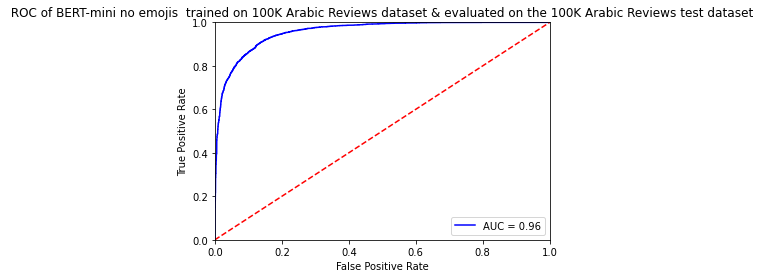

In [60]:
# Evaluate on unseen test dataset
evaluate_dataset(X_test, y_test,"BERT-mini no emojis", "100K Arabic Reviews", "100K Arabic Reviews test")

AUC: 0.6306
Accuracy: 57.73%


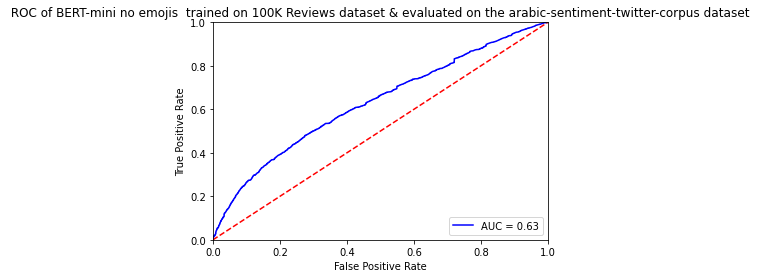

In [61]:
# Evaluate on the twitter corpus dataset
evaluate_dataset(df_twitter_corpus.tweet.values, df_twitter_corpus.label.values,"BERT-mini no emojis", "100K Reviews", "arabic-sentiment-twitter-corpus" )

AUC: 0.6842
Accuracy: 63.10%


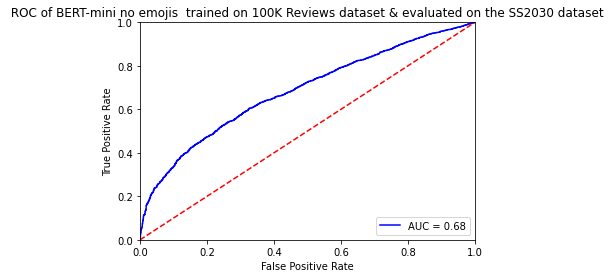

In [62]:
# Evaluate on the SS2030 Dataset
evaluate_dataset(df_ss2030.tweet.values, df_ss2030.label.values,"BERT-mini no emojis", "100K Reviews", "SS2030")

AUC: 0.6945
Accuracy: 55.48%


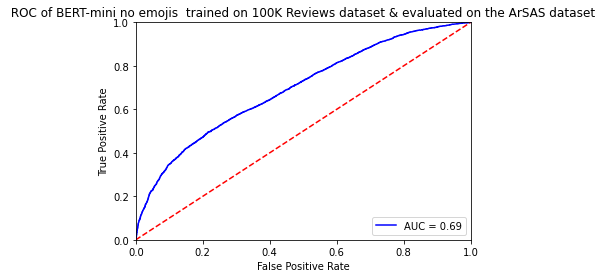

In [63]:
# Evaluate on the ArSAS Dataset
evaluate_dataset(df_arsas.tweet.values, df_arsas.label.values,"BERT-mini no emojis", "100K Reviews", "ArSAS")

<a id="2.4.3"> </a>
#### Train using the ArSAS Dataset

In [64]:

from sklearn.model_selection import train_test_split
MAX_LEN = 280
X = df_arsas.tweet.values
y = df_arsas.label.values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=2020)
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test,test_size=0.5, random_state=2020)


# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X_train[0]], text_preprocessing_fn=text_preprocessing_no_emojis)[0].squeeze().numpy())
print('Original: ', X_train[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train, text_preprocessing_fn=text_preprocessing_no_emojis)
val_inputs, val_masks = preprocessing_for_bert(X_val, text_preprocessing_fn=text_preprocessing_no_emojis)
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)
set_seed(42) 
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Original:  صحيح، لا ننسى أنه في عز أزمة الحصار والحرب الإعلامية ضد قطر تم الإنقلاب على محمد بن نايف.
Token IDs:  [2, 3559, 219, 1783, 20827, 2021, 1725, 3397, 6209, 10529, 29386, 6916, 3069, 4070, 1975, 11771, 1747, 2035, 1802, 17249, 18, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

AUC: 0.9406
Accuracy: 88.21%


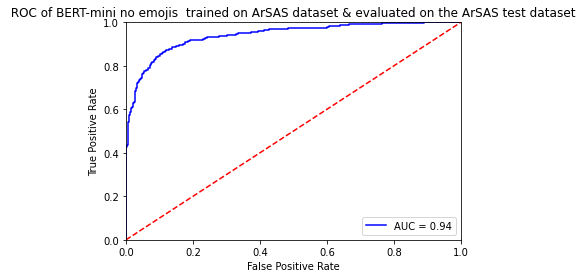

In [65]:
# Evaluate on the twitter corpus dataset
evaluate_dataset(X_test, y_test,"BERT-mini no emojis", "ArSAS", "ArSAS test")

AUC: 0.6788
Accuracy: 64.36%


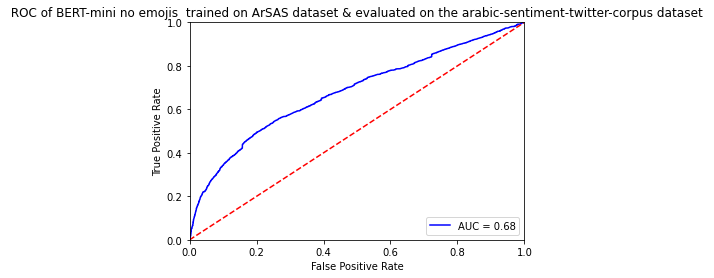

In [66]:
# Evaluate on the twitter corpus dataset
evaluate_dataset(df_twitter_corpus.tweet.values, df_twitter_corpus.label.values,"BERT-mini no emojis", "ArSAS", "arabic-sentiment-twitter-corpus")

AUC: 0.7192
Accuracy: 64.72%


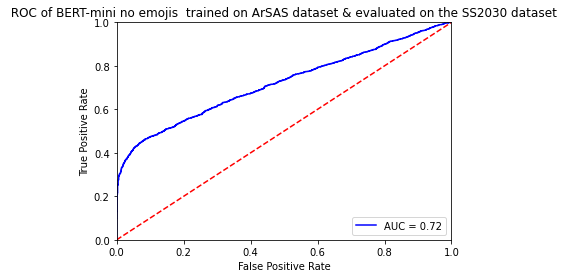

In [67]:
# Evaluate on the SS2030 Dataset
evaluate_dataset(df_ss2030.tweet.values, df_ss2030.label.values,"BERT-mini no emojis", "ArSAS", "SS2030")

AUC: 0.7226
Accuracy: 64.10%


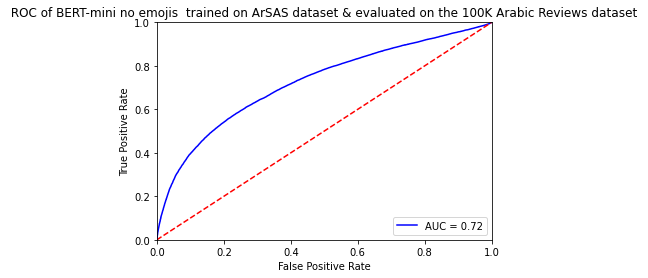

In [68]:
# Evaluate on the 100k reviews Dataset
evaluate_dataset(df_reviews.tweet.values, df_reviews.label.values,"BERT-mini no emojis", "ArSAS", "100K Arabic Reviews")

<a id="2.4.4"> </a>
#### Summary of performance on test datasets


| training dataset | test subset accuracy |  arabic-sentiment-twitter-corpus accuracy | SS2030 accuracy | 100k reviews accuracy | ArSAS accuracy
| :---: | :---: | :---: | :---: | :---: | :---: |
| arabic-sentiment-twitter-corpus | 0.785 | - | 0.579 | 0.570 | 0.697
| SS2030 | 0.847 | 0.492 | - | 0.502 | 0.628
| 100k reviews | 0.885 | 0.585 | 0.626 | - | 0.547
| ArSAS | 0.879 | 0.616 | 0.641 | 0.641 | - |

<center><i>numbers shown represent accuracy</i></center>

**The model trained on the ArSAS dataset appears to be generalizing better on the other test datasets (higher accuracy). Given that promising result, let's try using ArSAS to train bert-base**

<a id="2.4.5"> </a>
#### Train BERT-base Using the ArSAS Dataset

In [69]:

from sklearn.model_selection import train_test_split
MAX_LEN = 280
X = df_arsas.tweet.values
y = df_arsas.label.values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=2020)
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test,test_size=0.5, random_state=2020)


# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X_train[0]], version="base", text_preprocessing_fn=text_preprocessing_no_emojis)[0].squeeze().numpy())
print('Original: ', X_train[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train, version="base", text_preprocessing_fn=text_preprocessing_no_emojis)
val_inputs, val_masks = preprocessing_for_bert(X_val, version="base", text_preprocessing_fn=text_preprocessing_no_emojis)
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)
set_seed(42) 
bert_classifier, optimizer, scheduler = initialize_model(epochs=2, version="base")
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Original:  صحيح، لا ننسى أنه في عز أزمة الحصار والحرب الإعلامية ضد قطر تم الإنقلاب على محمد بن نايف.
Token IDs:  [2, 3559, 219, 1783, 20827, 2021, 1725, 3397, 6209, 10529, 29386, 6916, 3069, 4070, 1975, 11771, 1747, 2035, 1802, 17249, 18, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

AUC: 0.9564
Accuracy: 90.16%


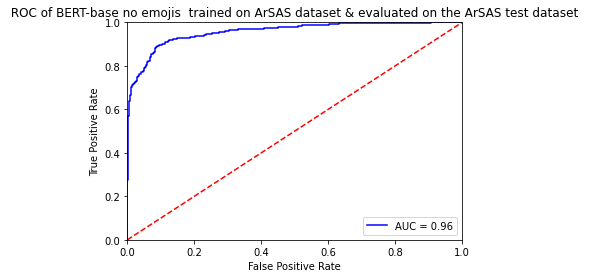

In [70]:
# Evaluate on the ArSAS test set
evaluate_dataset(X_test, y_test,"BERT-base no emojis", "ArSAS", "ArSAS test")

AUC: 0.6935
Accuracy: 65.50%


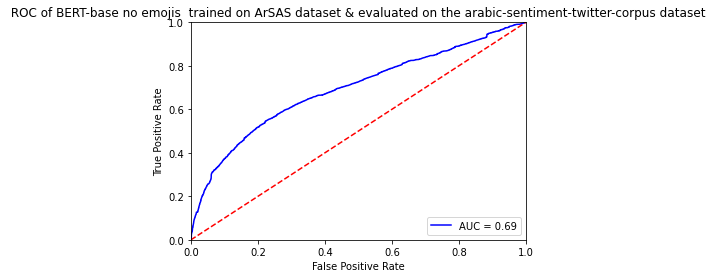

In [71]:
# Evaluate on the twitter corpus dataset
evaluate_dataset(df_twitter_corpus.tweet.values, df_twitter_corpus.label.values,"BERT-base no emojis", "ArSAS", "arabic-sentiment-twitter-corpus")

AUC: 0.7879
Accuracy: 68.25%


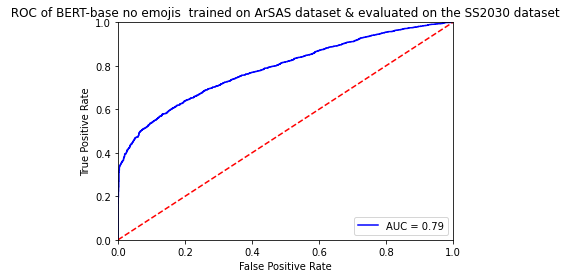

In [72]:
# Evaluate on the SS2030 Dataset
evaluate_dataset(df_ss2030.tweet.values, df_ss2030.label.values,"BERT-base no emojis", "ArSAS", "SS2030")

AUC: 0.8032
Accuracy: 74.15%


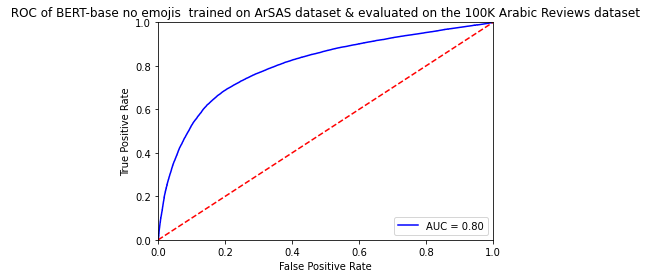

In [73]:
# Evaluate on the 100k reviews Dataset
evaluate_dataset(df_reviews.tweet.values, df_reviews.label.values,"BERT-base no emojis", "ArSAS", "100K Arabic Reviews")

As expected, BERT-base (no emojis) trained on ArSAS yields the best results yet in terms of generalizing on unseen test datasets

<a id="3"> </a>
# Final summary of all experiments

| model | with emojis| training dataset  |  arabic-sentiment-twitter-corpus accuracy | SS2030 accuracy | 100k reviews accuracy | ArSAS accuracy 
| :---: | :---: | :---: |  :---: | :---: | :---: | :---: |
| RandomForestClassifier | Yes | arabic-sentiment-twitter-corpus | *0.798*| 0.550 | 0.585 | 0.659 
| BERT-mini| Yes | arabic-sentiment-twitter-corpus | *0.900*| 0.639 | 0.599 | 0.691 
| BERT-mini| No | arabic-sentiment-twitter-corpus | *0.785* | 0.579 | 0.570 | **0.697** 
| BERT-base | No | arabic-sentiment-twitter-corpus | *0.803*  |  0.652| 0.652| **0.699** 
| BERT-mini| No | SS2030  | 0.492 | *0.847* | 0.502 | 0.628 
| BERT-mini| No | 100k reviews  | 0.585 | 0.626 | *0.885* | 0.547 
| BERT-mini| No | ArSAS | **0.616** | **0.641** | **0.641** | *0.879*
| BERT-base | No | ArSAS | ***0.648*** | ***0.679*** | ***0.741*** |*0.899*

<center><i>numbers shown represent accuracy</i></center>


**Notes:**
* *Italic numbers on the diagonal represent accuracies of the unseen test subsets (same dataset as training set)*
* *Bold numbers represent the highest BERT-base and BERT-mini accuracies for each external dataset/column (excluding the test subset of training dataset)*

### Summary & Conclusion

#### Summary of experiments
In this notebook my goal was to train an Arabic sentiment analysis classifier that is robust and has consistent performance regardless of the dataset used to evaluate it. Here's a summary of the experiments I've done:
- I first tried the classic ML approach and found that while it has a fast training time and good performance (measured by accuracy score) on the test subset of the dataset it's trained on, its performance significantly dropped when evaluated on other datasets.
- Then I tried a finetuning approach on a DL model that is pretrained on a very large corpus of Arabic text. The first model I tried in this category was a BERT-mini model that *did not* discard emojis in its preprocessing step. Similarly to the classical ML approach, this model performed well on the test subset of the dataset it's trained on, but failed to generalize on the other test datasets.
- I attempted a version of the same model that removes emojis in its preprocessing step. This caused the accuracy scores to drop both on the test subset and the other test datasets. This tells us that the model had been using emojis as sentiment cues. This is an undesired behavior because we want a model that infers sentiment from Arabic text, not from emojis. 
- The next step was to change the model to BERT-base which is a more complex version that has 10x more parameters than BERT-mini. This improved the performance on the ss2030 and 100k reviews datasets, but the accuracy on ArSAS didn't budge as much.
- After trying different versions of the model, changing the training dataset seemed like a logical next experiment. The dataset that showed the best performance improvement in terms of accuracy on unseen datasets, was shown to be ArSAS. 
- Given that result, I next trained a BERT-base model using ArSAS, and this version ended up outperforming the BERT-base model trained on the arabic-sentiment-twitter-corpus.

#### Conclusion:
- Out of the different model/training dataset combinations I've tried in this notebook, BERT-base trained on ArSAS proved to be the best one for the task of Arabic text Sentiment analysis.
- Even though the datasets all (except for the 100k Reviews Dataset) consist of dialectical Arabic tweets, they seem to have intrinsic differences in terms of topics and vocabulary, this is discussed in more details in the companion dataset analysis [notebook](https://www.kaggle.com/yasmeenhany/dataset-analysis). This makes it hard for a model trained on one to generalize well on others. 